In [1]:
# data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib
matplotlib.style.use('ggplot')

# Stats/Regresions Packages
from sklearn import linear_model
from sklearn.metrics import r2_score

# make sure charts appear in the notebook:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [3]:
food = pd.read_csv('../../datasets/discrim.csv')

### 1. EDA

In [4]:
# For simplicity I'm just going to drop any of the stores with missing price items.
# If you want to get fancy you can impute.
food = food[~food.psoda.isnull() & ~food.pfries.isnull() & ~food.pentree.isnull()]

In [24]:
food.head()

,psoda,pfries,pentree,wagest,nmgrs,nregs,hrsopen,emp,compown,chain,...,NJ,BK,KFC,RR,empl,wagestl,incomel,hsevall,densityl,model1_resid
0,1.12,1.06,1.02,4.25,3.0,5.0,16.0,27.5,1,3,...,1,0,0,1,3.314186,1.446919,10.704008,11.906993,8.301522,-0.167051
1,1.06,0.91,0.95,4.75,3.0,3.0,16.5,21.5,0,1,...,1,1,0,0,3.068053,1.558145,10.704008,11.906993,8.301522,-0.146436
2,1.06,0.91,0.98,4.25,3.0,5.0,18.0,30.0,0,1,...,1,1,0,0,3.401197,1.446919,10.625319,12.038837,9.341369,0.135279
3,1.12,1.02,1.06,5.00,4.0,5.0,16.0,27.5,0,3,...,1,0,0,1,3.314186,1.609438,10.827072,12.052921,9.029418,-0.076776
5,1.06,0.95,1.01,4.25,4.0,4.0,15.0,17.5,0,1,...,1,1,0,0,2.862201,1.446919,10.703581,11.904968,8.394800,-0.044696


In [5]:
# drop the rows without prppov and prpblck, our targets of interest
food = food[~food.prppov.isnull() & ~food.prpblck.isnull()]
food.shape

(386, 24)

In [6]:
# for wagest, nmgrs, nregs, emp, i will impute the median by store type 
# for the missing values

In [7]:
def impute_medians(df, cols=[]):
    for col in cols:
        mval = df[col].median()
        df.loc[df[col].isnull(), col] = mval
    return df

food = food.groupby('chain').apply(impute_medians, cols=['wagest','nmgrs','nregs','emp'])

In [8]:
# for density and crmrte i will impute the median by county:
food = food.groupby('county').apply(impute_medians, cols=['density','crmrte'])

In [9]:
#### First and foremost, I want to see if I can reproduce the results of the paper
### To do that I have to transform certain variables as Log values and leave others as is
###  Then, I am first going to predict price of entree from variables that could
#### reasonably impact the price:

# I'll use statsmodels so I can get the summary.

In [10]:
# Let's look at the price of entree specifically as our target.
# I want to see if these stores are charging more for fries when the proportion
# of poor people or black people in the area is higher. 

# I could just construct a regression right off the bat predicting price of 
# fries from black proportion, but what if it was other variables that happened
# to be correlated with these predictors that were actually responsible?

### So I am first going to exlcude the Black proportion from the model and then add it

In [11]:
#### Here is where I transform certain variables and leave others as is
logcols = ['emp','wagest','income', 'hseval','density']
asis = ['prpblck','crmrte','prpncar','compown','prppov','nstores','NJ','BK','KFC','RR']
target = 'pentree'

In [12]:
for colm in logcols:
    try:
        food[colm+'l'] = np.log(food[colm].values.reshape(-1, 1))
    except:
        continue
food.columns

Index(['psoda', 'pfries', 'pentree', 'wagest', 'nmgrs', 'nregs', 'hrsopen',
       'emp', 'compown', 'chain', 'density', 'crmrte', 'state', 'prpblck',
       'prppov', 'prpncar', 'hseval', 'nstores', 'income', 'county', 'NJ',
       'BK', 'KFC', 'RR', 'empl', 'wagestl', 'incomel', 'hsevall', 'densityl'],
      dtype='object')

In [13]:
#### Here I can see that almost all variables have a similar mean and hence no Scaling is necessary
food.describe()

,psoda,pfries,pentree,wagest,nmgrs,nregs,hrsopen,emp,compown,chain,...,county,NJ,BK,KFC,RR,empl,wagestl,incomel,hsevall,densityl
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,...,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,1.044482,0.921554,1.325440,4.613575,3.411399,3.588083,14.335492,17.294041,0.339378,2.111399,...,13.839378,0.805699,0.419689,0.202073,0.225389,2.731496,1.526370,10.715762,11.826658,7.993179
std,0.087872,0.105445,0.644309,0.339944,1.018032,1.233204,2.706320,8.680045,0.474113,1.116825,...,8.066935,0.396175,0.494149,0.402067,0.418380,0.498763,0.072178,0.285235,0.389808,0.986177
min,0.730000,0.670000,0.520000,4.250000,1.000000,1.000000,7.000000,3.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.098612,1.446919,9.675269,10.431170,5.093750
25%,0.980000,0.850000,0.950000,4.250000,3.000000,3.000000,12.000000,11.125000,0.000000,1.000000,...,6.000000,1.000000,0.000000,0.000000,0.000000,2.409008,1.446919,10.535785,11.566433,7.422224
50%,1.060000,0.925000,1.020000,4.500000,3.000000,3.000000,15.000000,16.125000,0.000000,2.000000,...,15.000000,1.000000,0.000000,0.000000,0.000000,2.780341,1.504077,10.741925,11.864990,7.970049
75%,1.070000,1.000000,1.470000,4.870000,4.000000,4.000000,16.000000,20.500000,1.000000,3.000000,...,20.000000,1.000000,1.000000,0.000000,0.000000,3.020425,1.583094,10.901395,12.081501,8.690657
max,1.490000,1.270000,3.950000,5.750000,10.000000,8.000000,24.000000,67.500000,1.000000,4.000000,...,29.000000,1.000000,1.000000,1.000000,1.000000,4.212128,1.749200,11.824292,13.067696,10.631929


In [14]:
#### This is where I build my Regression Model and see how the results compare with the Table 2 of the paper
import statsmodels.formula.api as smf
f = 'pentree ~ C(county)+C(chain)+empl+wagestl+incomel+hsevall+densityl+BK+KFC+RR+crmrte+prpncar+compown+prppov+nstores'
model = smf.ols(f, data=food)
results1 = model.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pentree   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     46.95
Date:                Fri, 28 Sep 2018   Prob (F-statistic):          1.12e-116
Time:                        16:52:13   Log-Likelihood:                -13.453
No. Observations:                 386   AIC:                             110.9
Df Residuals:                     344   BIC:                             277.1
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.2515      0.997      2.259      0.025       0.291       4.212
C(county)[T.2]     -0.1149      0.116     -0.994      0.321      -0.342       0.113
C(county)[T.3]     -0.2015      0.286     -0.704      0.482      -0.764       0.361
C(county)[T.4]     -0.1795      0.119     -1.512      0.132      -0.413       0.054
C(county)[T.5]     -0.2554      0.108     -2.354      0.019      -0.469      -0.042
C(county)[T.6]     -0.3237      0.101     -3.220      0.001      -0.521      -0.126
C(county)[T.7]     -0.2841      0.142     -1.999      0.046      -0.564      -0.005
C(county)[T.8]     -0.3892      0.179     -2.170      0.031      -0.742      -0.036
C(county)[T.9]     -0.2440      0.131     -1.856      0.064      -0.503       0.015
C(county)[T.10]    -0.1336      0.112     -1.198      0.232      -0.353       0.086
C(county)[T.11]    -0.2431      0.116     -2.094      0.037      -0.471      -0.015
C(county)[T.12]    -0.1854      0.126     -1.471      0.142      -0.433       0.063
C(county)[T.13]    -0.2770      0.285     -0.971      0.332      -0.838       0.284
C(county)[T.14]    -0.1027      0.144     -0.713      0.477      -0.386       0.181
C(county)[T.15]    -0.1483      0.113     -1.309      0.191      -0.371       0.075
C(county)[T.16]    -0.2046      0.188     -1.088      0.277      -0.574       0.165
C(county)[T.17]     0.1644      0.119      1.379      0.169      -0.070       0.399
C(county)[T.18]    -0.0710      0.105     -0.679      0.498      -0.277       0.135
C(county)[T.19]    -0.1625      0.110     -1.471      0.142      -0.380       0.055
C(county)[T.20]    -0.2366      0.104     -2.276      0.023      -0.441      -0.032
C(county)[T.21]    -0.1979      0.116     -1.703      0.090      -0.426       0.031
C(county)[T.22]    -0.5147      0.163     -3.158      0.002      -0.835      -0.194
C(county)[T.23]    -0.1113      0.115     -0.967      0.334      -0.338       0.115
C(county)[T.24]    -0.0663      0.124     -0.533      0.594      -0.311       0.178
C(county)[T.25]    -0.3256      0.179     -1.814      0.071      -0.679       0.027
C(county)[T.26]    -0.2032      0.138     -1.470      0.143      -0.475       0.069
C(county)[T.27]    -0.1295      0.162     -0.799      0.425      -0.448       0.189
C(county)[T.28]    -0.0235      0.120     -0.195      0.846      -0.260       0.213
C(county)[T.29]    -0.2139      0.162     -1.317      0.189      -0.533       0.105
C(chain)[T.2]       0.9484      0.166      5.715      0.000       0.622       1.275
C(chain)[T.3]       0.2767      0.169      1.642      0.102      -0.055       0.608
C(chain)[T.4]       0.6266      0.334      1.877      0.061      -0.030       1.283
empl               -0.0641      0.035     -1.837      0.067      -0.133       0.005
wagestl             0.1761      0.222      0.795      0.427

In [15]:
##### The results do match!!
### So we have here R-Squared of 0.84 which is very close to the Rsquared of 0.83 in the Table 2 of the paper
#### Now let's go to the next step

In [16]:
############ I am now going to add prpblck rto the above and see if it is significant ###
import statsmodels.formula.api as smf
f = 'pentree ~ C(county)+C(chain)+prpblck+empl+wagestl+incomel+hsevall+densityl+BK+KFC+RR+crmrte+prpncar+compown+prppov+nstores'
model = smf.ols(f, data=food)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pentree   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     46.27
Date:                Fri, 28 Sep 2018   Prob (F-statistic):          1.31e-116
Time:                        16:52:14   Log-Likelihood:                -11.411
No. Observations:                 386   AIC:                             108.8
Df Residuals:                     343   BIC:                             278.9
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.2593      0.993      2.275      0.024       0.306       4.212
C(county)[T.2]     -0.1327      0.116     -1.148      0.252      -0.360       0.095
C(county)[T.3]     -0.2177      0.285     -0.764      0.446      -0.779       0.343
C(county)[T.4]     -0.1737      0.118     -1.469      0.143      -0.406       0.059
C(county)[T.5]     -0.2701      0.108     -2.493      0.013      -0.483      -0.057
C(county)[T.6]     -0.3135      0.100     -3.126      0.002      -0.511      -0.116
C(county)[T.7]     -0.2987      0.142     -2.107      0.036      -0.578      -0.020
C(county)[T.8]     -0.3812      0.179     -2.133      0.034      -0.733      -0.030
C(county)[T.9]     -0.2125      0.132     -1.610      0.108      -0.472       0.047
C(county)[T.10]    -0.1803      0.114     -1.585      0.114      -0.404       0.043
C(county)[T.11]    -0.2225      0.116     -1.916      0.056      -0.451       0.006
C(county)[T.12]    -0.1891      0.126     -1.505      0.133      -0.436       0.058
C(county)[T.13]    -0.2725      0.284     -0.958      0.339      -0.832       0.287
C(county)[T.14]    -0.0483      0.146     -0.330      0.742      -0.336       0.240
C(county)[T.15]    -0.1086      0.115     -0.946      0.345      -0.334       0.117
C(county)[T.16]    -0.1404      0.190     -0.738      0.461      -0.515       0.234
C(county)[T.17]     0.1568      0.119      1.320      0.188      -0.077       0.391
C(county)[T.18]    -0.0837      0.105     -0.800      0.424      -0.289       0.122
C(county)[T.19]    -0.1820      0.111     -1.647      0.101      -0.399       0.035
C(county)[T.20]    -0.2299      0.104     -2.219      0.027      -0.434      -0.026
C(county)[T.21]    -0.2172      0.116     -1.869      0.062      -0.446       0.011
C(county)[T.22]    -0.4941      0.163     -3.036      0.003      -0.814      -0.174
C(county)[T.23]    -0.1089      0.115     -0.949      0.343      -0.334       0.117
C(county)[T.24]    -0.0861      0.124     -0.692      0.489      -0.331       0.159
C(county)[T.25]    -0.2933      0.180     -1.633      0.103      -0.647       0.060
C(county)[T.26]    -0.2388      0.139     -1.718      0.087      -0.512       0.035
C(county)[T.27]    -0.1289      0.161     -0.798      0.425      -0.447       0.189
C(county)[T.28]    -0.0558      0.121     -0.461      0.645      -0.294       0.182
C(county)[T.29]    -0.2134      0.162     -1.319      0.188      -0.532       0.105
C(chain)[T.2]       0.9471      0.165      5.729      0.000       0.622       1.272
C(chain)[T.3]       0.2776      0.168      1.653      0.099      -0.053       0.608
C(chain)[T.4]       0.6313      0.333      1.898      0.058      -0.023       1.285
prpblck             0.2362      0.124      1.910      0.057      -0.007       0.479
empl               -0.0693      0.035     -1.987      0.048

In [17]:
# I see that the results are close to significant for the proportion black
# predictor even after controlling for the variance in price accounted
# for by multiple variables in the data set. 

In [18]:
# This is a pretty basic analysis and there is a lot more you could do,
# but should whet your appetite for what is possible!

<h4>Another way to check the effect of prpblck is the following

In [19]:
# I'm going to extract the residuals out of this model:
resids = results1.resid

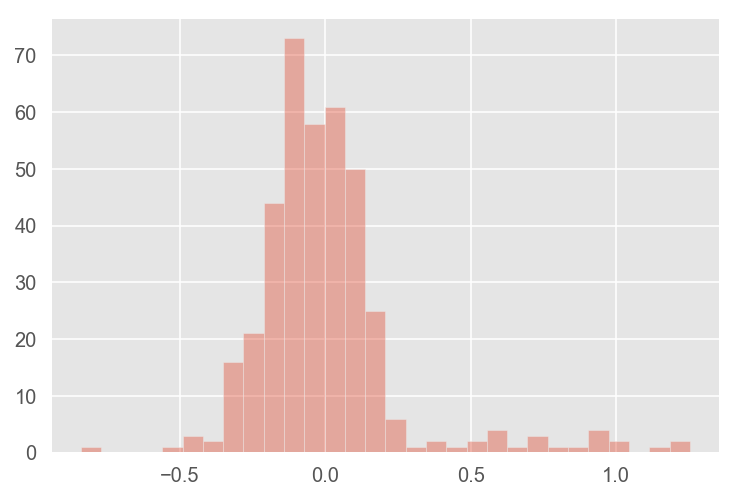

In [20]:
sns.distplot(resids, kde=False, bins=30)

In [21]:
# nice, normally distributed resids. 
# The residuals represent the variance remaining in the price of fries not 
# accounted for by the predictors in my model (at least in a linear sense,
# if there are nonlinear effects the linear regression won't capture them
# adequately.)

# I'm now going to make my target the residuals, and predict those with
# the prpblck and other variables. If there are significant effects 
# of these predictors on the residuals then I can be sure that the variance
# they are accounting for is not due to wage or chain.

In [22]:
food['model1_resid'] = resids
model2 = smf.ols('model1_resid ~ prpblck+prpncar', data=food)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           model1_resid   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.218
Date:                Fri, 28 Sep 2018   Prob (F-statistic):              0.297
Time:                        16:52:20   Log-Likelihood:                -12.230
No. Observations:                 386   AIC:                             30.46
Df Residuals:                     383   BIC:                             42.33
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.018      0.017      0.986      -0.035       0.035
prpblck        0.1418      0.091      1.561      0.119      -0.037       0.321
prpncar       -0.1454      0.142     -1.027      0.305      -0.424       0.133
==============================================================================
Omnibus:                      183.092   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              980.409
Skew:                           2.001   Prob(JB):                    1.28e-213
Kurtosis:                       9.704   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#### Though the proportion of Black residents is not quite there as "Significant" enough to 
###   to explain the Residuals, it does come close.